# DSP Architectures - LAB 5 - Python

This notebook presents two approaches for analysis of WAV recording of fetus hearth rate (cardiotocography):

- FFT of FHR signal

- Hear Rate extraction using Pan-Tompkins algorithm

- Hear Rate extraction using HeartPy library

**Author:**

Piotr Zieliński, 237457

In [21]:
# Import Required Libraries
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
import numpy as np
from tools import FileDirHelper
from tools import matplotlib_config
from scipy.fft import rfft, rfftfreq
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt
import heartpy as hp
import pandas as pd
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import filtfilt
from derivative import dxdt

#Config matplotlib
matplotlib_config()

## WAV file

Read .WAV file and plot its content.

Sampling frequency: 500 Hz.


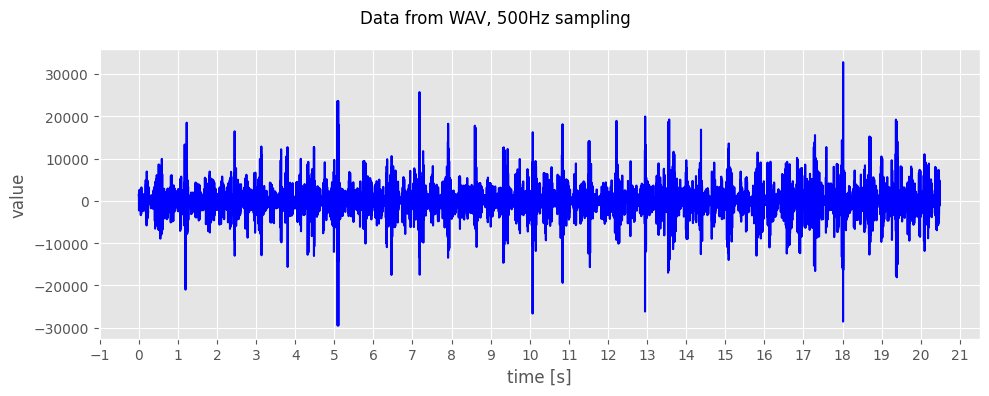

In [22]:
sampling_freq, data = wavfile.read("./Source/LAB5_500HzFHR.wav")

print(f'Sampling frequency: {sampling_freq} Hz.')

data = np.array(data)
time = np.arange(0, data.size) * (1.0 / sampling_freq)

fig, ax = plt.subplots(1,1, figsize = (10,4), dpi = 100)
fig_name = f"Data from WAV, {sampling_freq}Hz sampling"
fig.suptitle(fig_name)
ax.plot(time, data,
            c='b', label='original data')
ax.set_xlabel('time [s]')
ax.set_ylabel('value')
fig.tight_layout()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

## FFT

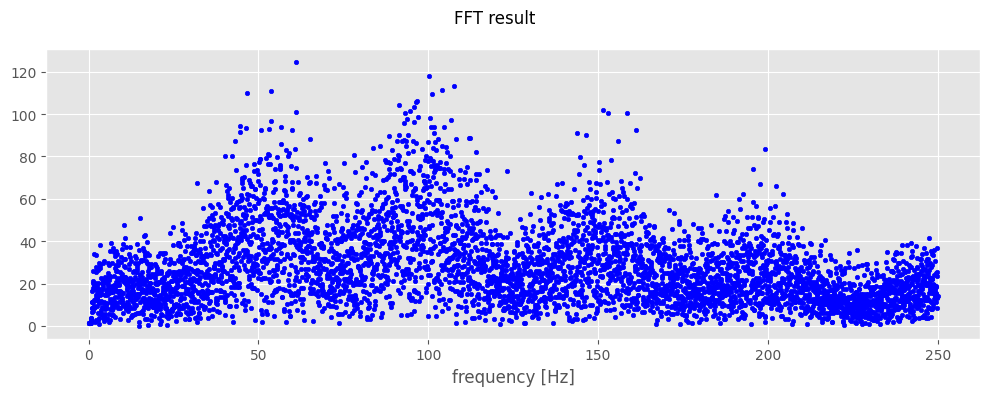

In [23]:
xf = rfftfreq(data.size, (1/sampling_freq))
yf = np.abs(rfft(data))/data.size

# Plot the fft result.
fig, ax = plt.subplots(1,1, figsize = (10,4), dpi = 100)
fig_name = "FFT result"
fig.suptitle(fig_name)
ax.scatter(xf, yf, label='FFT', c= 'b', s=10)
ax.set_xlabel('frequency [Hz]')
fig.tight_layout()

## Hearth Rate extraction using Pan-Tompkins Algorithm

### Bandpass

Text(0.5, 1.0, 'Bandpassed Signal')

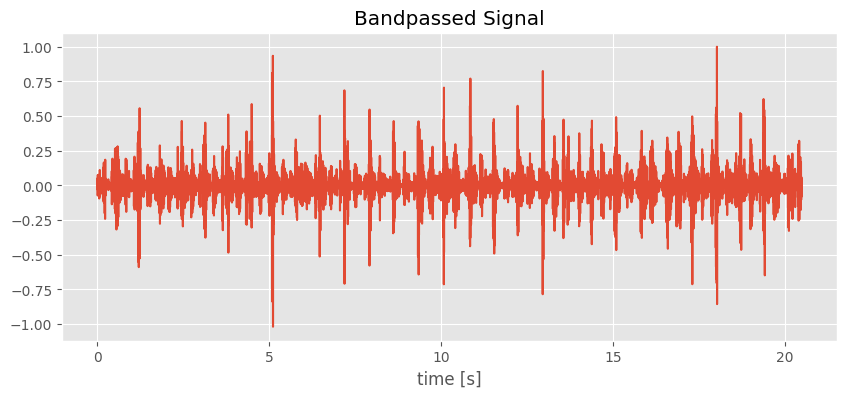

In [24]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='bandpass')
    y = lfilter(b, a, data)
    y = y/y.max()
    return y

# Bandpass Filter
bpass = butter_bandpass_filter(data.copy(), lowcut=80, highcut=220,
                                fs=sampling_freq, order=5)

# Plotting bandpassed signal
plt.figure(figsize = (10,4), dpi = 100)
plt.plot(time, bpass)
plt.xlabel('time [s]')
plt.title("Bandpassed Signal")

### FFT after bandpass


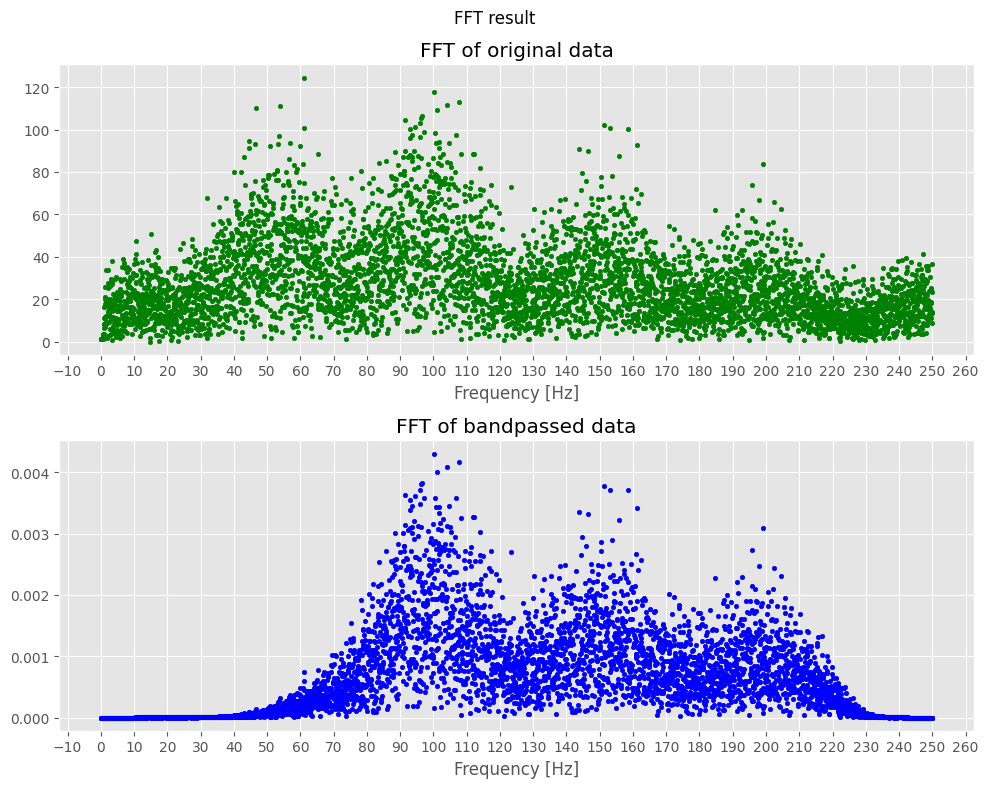

In [25]:
xf_bp = rfftfreq(bpass.size, (1/sampling_freq))
yf_bp = np.abs(rfft(bpass))/bpass.size

# Plot the fft result.
fig, [ax1, ax2] = plt.subplots(2,1, figsize = (10,8), dpi = 100)
fig_name = "FFT result"
fig.suptitle(fig_name)

ax1.set_title('FFT of original data')
ax2.set_title('FFT of bandpassed data')
ax1.scatter(xf, yf, label='FFT of original data', c= 'green', s=10)
ax2.scatter(xf_bp, yf_bp, label='FFT of bandpassed data', c= 'blue', s=10)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.set_xlabel('Frequency [Hz]')
ax2.set_xlabel('Frequency [Hz]')
fig.tight_layout()

### Derivative

Text(0.5, 1.0, 'Derivative Signal')

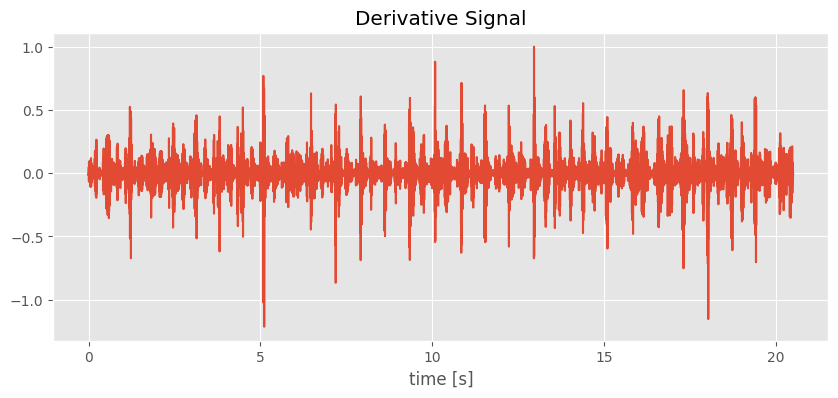

In [26]:
def derivative(time, data, sample_rate):
    result = dxdt(data.copy(), time, kind="finite_difference", k=1)
    result = result/result.max()
    return result

# Derivative Function
der = derivative(time, bpass.copy(), sampling_freq)

# Plotting derived signal
plt.figure(figsize = (10,4), dpi = 100)
plt.plot(time, der)
plt.xlabel('time [s]')
plt.title("Derivative Signal")

### Squaring of the signal

Text(0.5, 1.0, 'Squared Signal')

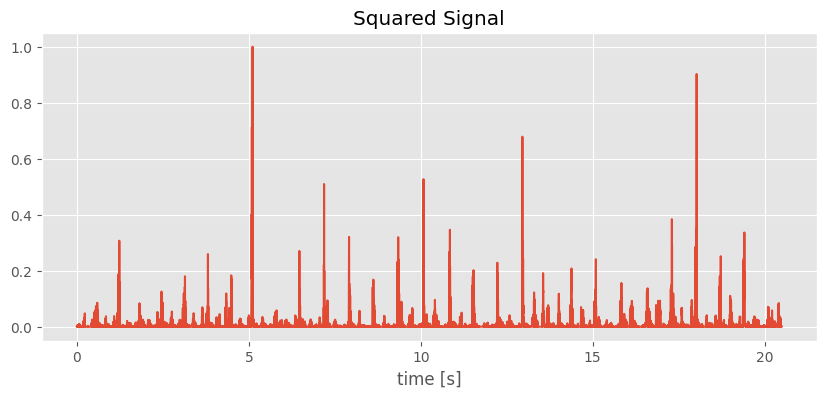

In [27]:
def squaring(signal):  
    result = signal**2
    result = result/result.max()
    return result

# Squaring Function
sqr = squaring(der.copy())

# Plotting squared signal
plt.figure(figsize = (10,4), dpi = 100)
plt.plot(time, sqr)
plt.xlabel('time [s]')
plt.title("Squared Signal")

### Moving Window Integrator

Text(0.5, 1.0, 'Moving Window Integrated Signal')

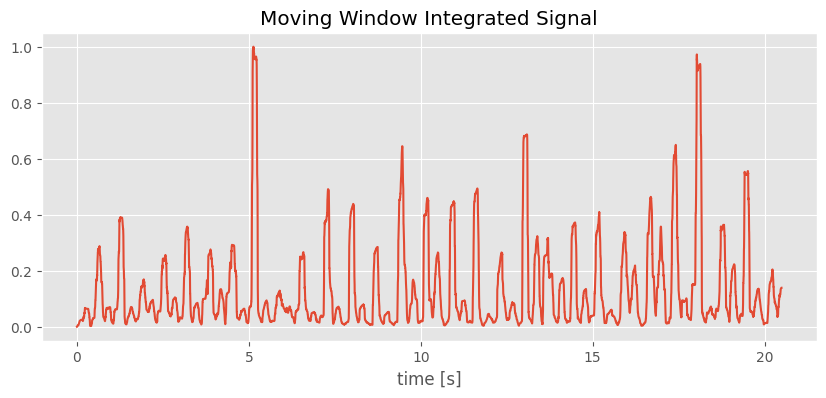

In [28]:
def moving_window_integration(signal, sample_rate):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The moving window integration process is done to obtain
    information about both the slope and width of the QRS complex.
    A window size of 0.15*(sample frequency) is used for more
    accurate results.

    The moving window integration has the recursive equation:
      y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N

      where N is the number of samples in the width of integration
      window.
    '''

    # Initialize result and window size for integration
    result = signal.copy()
    win_size = round(0.150 * sample_rate)
    sum = 0

    # Calculate the sum for the first N terms
    for j in range(win_size):
      sum += signal[j]/win_size
      result[j] = sum

    # Apply the moving window integration using the equation given
    for index in range(win_size, len(signal)):
      sum += signal[index]/win_size
      sum -= signal[index-win_size]/win_size
      result[index] = sum

    result = result/result.max()

    return result

# Moving Window Integration Function
mwin = moving_window_integration(sqr.copy(), sampling_freq)
mwin = mwin/mwin.max()

# Plotting moving window integrated signal
plt.figure(figsize = (10,4), dpi = 100)
plt.plot(time, mwin)
plt.xlabel('time [s]')
plt.title("Moving Window Integrated Signal")

### Find peaks

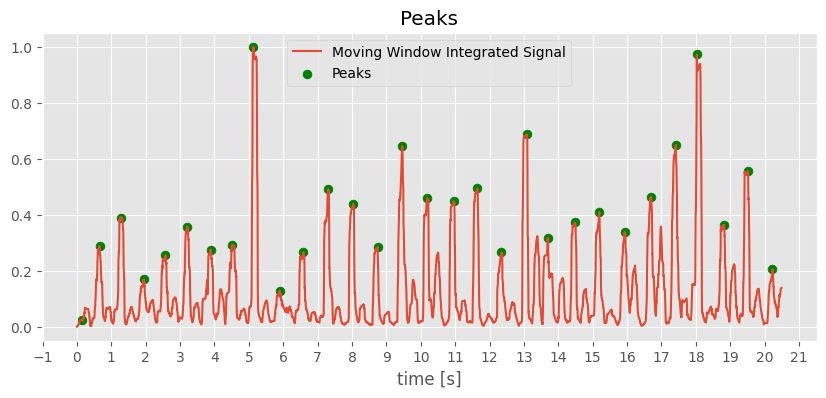

In [29]:
peak_min_width_s = 0.3
peak_min_width = peak_min_width_s * sampling_freq

peaks_id, _ = find_peaks(mwin, distance=0.5*sampling_freq)#, prominence=30)
peaks_time = np.take(time, peaks_id)
peaks_value = np.take(mwin, peaks_id)

fig, ax = plt.subplots(1,1, figsize = (10,4), dpi = 100)
ax.plot(time, mwin, label="Moving Window Integrated Signal")
ax.scatter(peaks_time, peaks_value, label="Peaks", c="green", s=40)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('time [s]')
plt.title("Peaks")
plt.legend()

### All operations on one plot

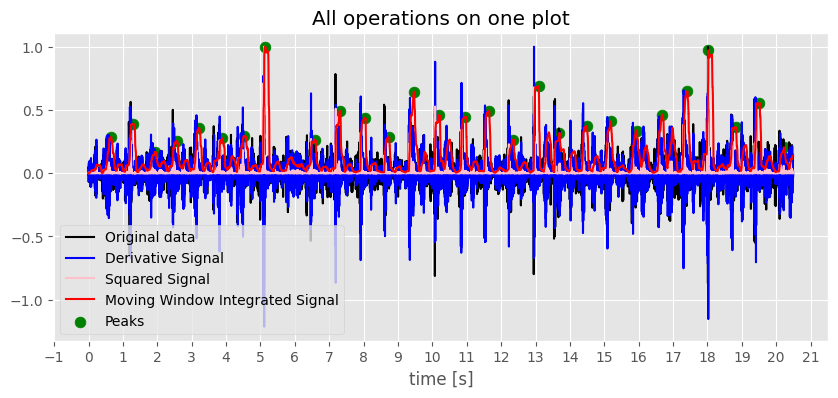

In [30]:
# Plotting moving window integrated signal
fig, ax = plt.subplots(1,1, figsize = (10,4), dpi = 100)
ax.plot(time, data/data.max(), label="Original data", c="black")
ax.plot(time, der, label="Derivative Signal", c="blue")
ax.plot(time, sqr, label="Squared Signal", c="pink")
ax.plot(time, mwin, label="Moving Window Integrated Signal", c="red")
ax.scatter(peaks_time, peaks_value, label="Peaks", c="green", s=60)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('time [s]')
plt.title("All operations on one plot")
plt.legend()

### Calculate BPM form average peak to peak time


In [31]:
peak_time_diffs = np.diff(peaks_time)
BPMs = np.ones_like(peak_time_diffs)/peak_time_diffs * 60
print(f'Average BPM is: {BPMs.mean():2} BPM.')

Average BPM is: 87.49420767732411 s.


## Hearth Rate detection using Heartpy

Extract heart beat rate using heartpy library.

Detected hearthrate is: 89.29 BPM.


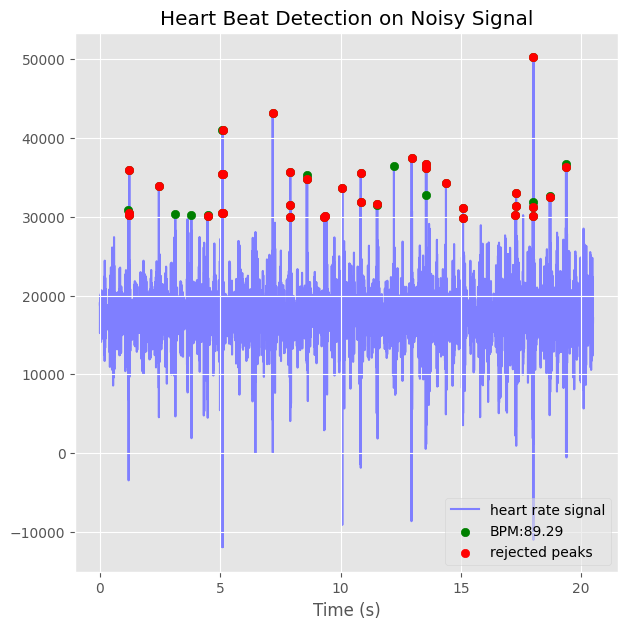

In [32]:
import warnings
warnings.filterwarnings('ignore')
working_data, measurements = hp.process(data, 
                                        sampling_freq)
print(f"Detected hearthrate is: {measurements['bpm']:.2f} BPM.")

hp.plotter(working_data, measurements, title='Heart Beat Detection on Noisy Signal')
warnings.filterwarnings('default')